# Early-warning signals for a collapse of the AMOC

How can we determine if a physical system is approching a critical transition:

- Incresing variance 
- Increasing auto-correlation

These increases can also result from incresing variance and auto-correlation of external noise (false alarm). An alternative early warning signal (EWS) is required. Consider the restoring rate $\lambda$ for a system close to its equilibrium:

$$ \frac{dx}{dt} \approx \lambda x + \eta $$

where $\eta$ denotes a stochastic forcing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import random

## Model 1

The following model approches a critical transition:

$$ \dot{x} = -x^3 + x - T + \eta(t)$$

- $\eta(t)$ is white noise with standard deviation $\sigma$ = 0.2.
- $T$ is linearly increasing from -1 to 1.

This system destabalises once $T > \frac{2}{3\sqrt{3}}$ when no noise is present. This model can be simulated using the [Euler-Maruyama method](https://en.wikipedia.org/wiki/Euler-Maruyama_method) for stochastic differential equations:

$$ x_{i+1} = x_{i} + (-x_i^3 + x_i - T(t_i))\Delta t + \sigma dW$$ 

- dW is a normally distributed value with expected value $\mu = 0$ and variance $\sigma^2 = \Delta t$.


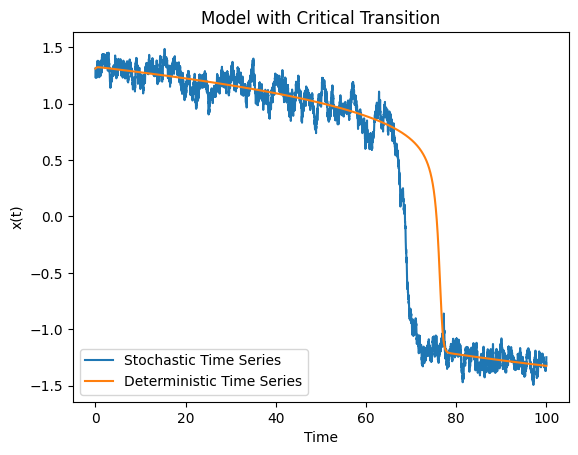

In [14]:
# time-space
n = 10000
tmax = 100
t = np.linspace(0.0, tmax, n)
dt = t[1] - t[0]

# parameters
sigma = 0.2
T = 2 * t / tmax - 1

# initialise time series
model1 = np.zeros(n)
model1_without_noise = np.zeros(n)
model1[0] = model1_without_noise[0] = 1.31 # initial value (close to equilibrium for T = -1)

# Euler-Maruyama method
for i in range(n - 1):
    model1[i + 1] = model1[i] + dt * (-model1[i]**3 + model1[i] - T[i]) + sigma * np.random.normal(loc=0.0, scale=np.sqrt(dt))

for i in range(n - 1):
    model1_without_noise[i + 1] = model1_without_noise[i] + dt * (-model1_without_noise[i]**3 + model1_without_noise[i] - T[i])

plt.title("Model with Critical Transition")
plt.plot(t, model1, label="Stochastic Time Series")
plt.plot(t, model1_without_noise, label="Deterministic Time Series")
plt.xlabel("Time")
plt.ylabel("x(t)")
plt.legend()

## Model 2

The following model does not have a critical transition:

$$ \dot{x} = -5x + \eta(t)$$

- $\eta(t)$ is auto-correlated noise.
- The standard deviation $\sigma$ is increasing linearly from 0.2 to 1.0.
- The AR(1) coefficient is increasing linearly from 0.1 to 0.95.

This model can be simulated using the Euler-Maruyama method:

$$ x_{t+1} = x_t + (-5x_t)\Delta t + \sigma dW $$

- dW is an auto-correlated signal with expected value $\mu = 0$ and variance $\sigma^2 = \Delta t$.


To generate an auto-correlated signal, use the following [AR(1) model](https://en.wikipedia.org/wiki/Autoregressive_model):

$$ X_{t} = \Phi X_{t-1} + \epsilon_{t} $$

- $\Phi$ is the AR(1) parameter.
- $\epsilon_{t}$ is a normally distributed random variable with expected value $\mu=0$ and variance $\sigma^2_\epsilon$.

The total variance of this signal is given by:

$$ \sigma^2 = \frac{\sigma^2_\epsilon}{1 - \Phi^2} $$

Text(0, 0.5, 'x(t)')

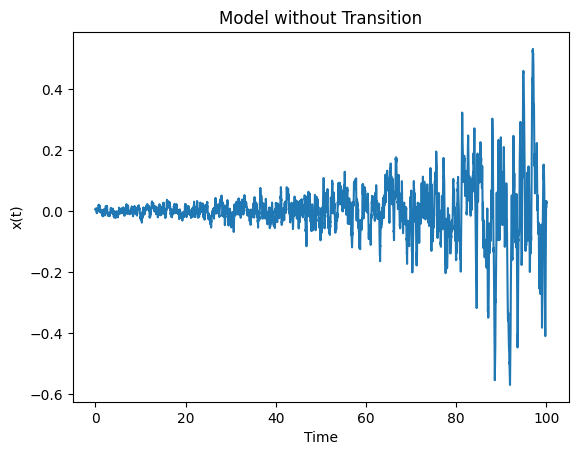

In [15]:
# auto-correlated noise generator
def autocorrelated_signal(n, phi, sigma=1.0):
    sigma_e = np.sqrt((sigma**2) * (1 - phi**2))
    
    signal = np.zeros(n)
    signal[0] = np.random.normal(loc=0.0, scale=sigma_e[0])
    
    for i in range(n - 1):
        signal[i + 1] = phi[i] * signal[i] + np.random.normal(loc=0.0, scale=sigma_e[0])

    return signal

# parameters
sigma = 0.8 * t / tmax + 0.2
phi = 0.85 * t / tmax + 0.1
signal = autocorrelated_signal(n, phi=phi, sigma=dt)

# initialize model
model2 = np.zeros(n)
model2[0] = signal[0]

# Euler-Maruyama method
for i in range(n - 1):
    model2[i + 1] = model2[i] + dt * -5 * model2[i] + sigma[i] * signal[i + 1]
    
plt.title("Model without Transition")
plt.plot(t, model2)
plt.xlabel("Time")
plt.ylabel("x(t)")

The following functions for measuring variance, autocorrelation and restoring rate were obtained from  [github](https://github.com/niklasboers/AMOC_EWS).

## Measuring variance

The function below calculates the moving average of the standard deviation of a time series x. It does this by sliding a window of width w one step at a time across the time series. At each step a linear model is fit to the window and the standard deviation of the residuals are calculated.


At the start and end of the time series, only half the window size is used. So if you use a window with a size w=2,000, the first and last 1,000 steps are calculated using a window of size w/2=1,000.

In [16]:
def runstd(x, w):
    n = x.shape[0]
    xs = np.zeros_like(x) # result
    
    # left side
    for i in range(w // 2):
        xw = x[: i + w // 2 + 1] # take a window of size w/2
        xw = xw - xw.mean() # centre the data by subtracting the mean
        if np.std(xw) > 0: # if the calculated standard deviation is valid
            lg = st.linregress(np.arange(xw.shape[0]), xw)[:] # fit a linear model to the window
            p0 = lg[0] # slope
            p1 = lg[1] # intercept
            xw = xw - p0 * np.arange(xw.shape[0]) - p1 # residuals 

            xs[i] = np.std(xw) # record the stddev of the residuals
        else:
            xs[i] = np.nan
            
    # right side
    for i in range(n - w // 2, n):
        xw = x[i - w // 2 + 1:]
        xw = xw - xw.mean()
        if np.std(xw) > 0:
            lg = st.linregress(np.arange(xw.shape[0]), xw)[:]
            p0 = lg[0]
            p1 = lg[1]
            xw = xw - p0 * np.arange(xw.shape[0]) - p1

            xs[i] = np.std(xw)
        else:
            xs[i] = np.nan
    
    # centre
    for i in range(w // 2, n - w // 2):
        xw = x[i - w // 2 : i + w // 2 + 1]
        xw = xw - xw.mean()
        if np.std(xw) > 0:
            lg = st.linregress(np.arange(xw.shape[0]), xw)[:]
            p0 = lg[0]
            p1 = lg[1]
            xw = xw - p0 * np.arange(xw.shape[0]) - p1

            xs[i] = np.std(xw)
        else:
            xs[i] = np.nan

    return xs

model1_stddev = runstd(model1, 2000)
model2_stddev = runstd(model2, 2000)

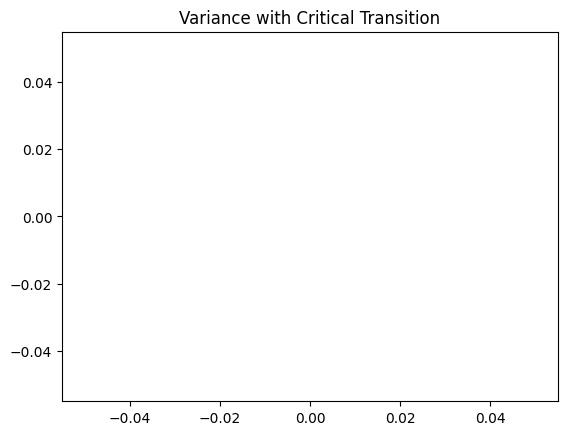

In [17]:
plt.title("Variance with Critical Transition")
plt.plot(t[10_000:60_000], model1_stddev[10_000:60_000]**2)

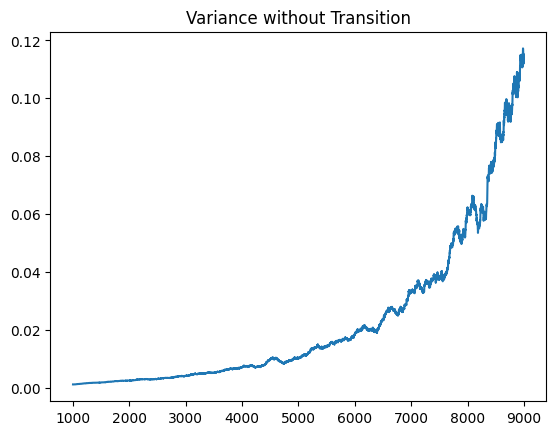

In [229]:
plt.title("Variance without Transition")
plt.plot(t[10_000:90_000], model2_stddev[10_000:90_000]**2)

## Measuring auto-correlation

The function below calculates the moving average of the lag-1 auto-correlation of a time series x, i.e the correlation between the time series and itself shifted by one. Again, a linear model was fit to a window of size w at each step and the residuals were obtained. The lag-1 auto-correlation of the residuals was then calculated.

In [199]:
def runac(x, w):
    n = x.shape[0]
    xs = np.zeros_like(x)
    
    # left side
    for i in range(w // 2):
        xw = x[: i + w // 2 + 1]
        xw = xw - xw.mean()
        if np.std(xw) > 0:
            lg = st.linregress(np.arange(xw.shape[0]), xw)[:] # fit a linear model
            p0 = lg[0] # slope
            p1 = lg[1] # intercept
            xw = xw - p0 * np.arange(xw.shape[0]) - p1 # residuals

            xs[i] = np.corrcoef(xw[1:], xw[:-1])[0,1] # lag1 autocorrelation coef of residuals
        else:
            xs[i] = np.nan

    for i in range(n - w // 2, n):
        xw = x[i - w // 2 + 1:]
        xw = xw - xw.mean()
        if np.std(xw) > 0:
            lg = st.linregress(np.arange(xw.shape[0]), xw)[:]
            p0 = lg[0]
            p1 = lg[1]
            xw = xw - p0 * np.arange(xw.shape[0]) - p1

            xs[i] = np.corrcoef(xw[1:], xw[:-1])[0,1]
        else:
            xs[i] = np.nan

    for i in range(w // 2, n - w // 2):
        xw = x[i - w // 2 : i + w // 2 + 1]
        xw = xw - xw.mean()
        if np.std(xw) > 0:
            lg = st.linregress(np.arange(xw.shape[0]), xw)[:]
            p0 = lg[0]
            p1 = lg[1]
            xw = xw - p0 * np.arange(xw.shape[0]) - p1
            xs[i] = np.corrcoef(xw[1:], xw[:-1])[0,1]
        else:
            xs[i] = np.nan

    return xs

model1_ac = runac(model1, 2000)
model2_ac = runac(model2, 2000)

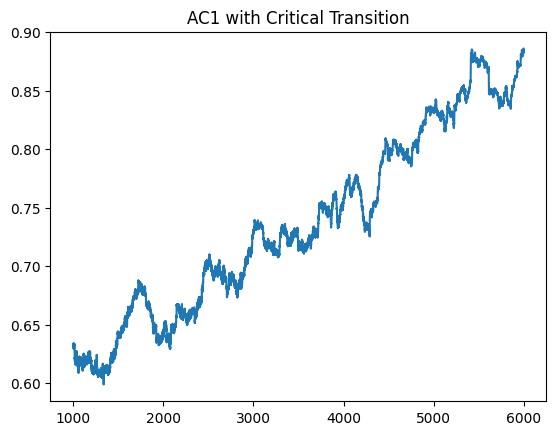

In [212]:
plt.title("AC1 with Critical Transition")
plt.plot(t[10_000:60_000], model1_ac[10_000:60_000])

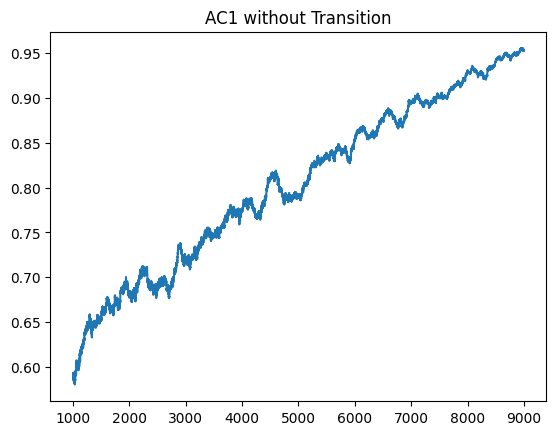

In [228]:
plt.title("AC1 without Transition")
plt.plot(t[10_000:90_000], model2_ac[10_000:90_000])

## Measuring restoring rate

The function below measures the moving average of the restoring rate for a given time series x. Again, the residuals are obtained for a given window and now the series dx is calculated by subtracting from the residuals itself shifted by one. Then a linear model is fit to this dx series and the resulting slope is returned.

In [203]:
def run_fit_a(x, w):
    n = x.shape[0]
    xs = np.zeros_like(x)

    for i in range(w // 2):
        xw = x[: i + w // 2 + 1]
        xw = xw - xw.mean()
        lg = st.linregress(np.arange(xw.shape[0]), xw)[:]
        p0 = lg[0]
        p1 = lg[1]

        xw = xw - p0 * np.arange(xw.shape[0]) - p1 # residuals

        dxw = xw[1:] - xw[:-1] # dx
        lg = st.linregress(xw[:-1], dxw)[:] # apply linear model to dx
        a = lg[0]
        b = lg[1]

        xs[i] = a # return slope

    for i in range(n - w // 2, n):
        xw = x[i - w // 2 + 1:]
        xw = xw - xw.mean()
        lg = st.linregress(np.arange(xw.shape[0]), xw)[:]
        p0 = lg[0]
        p1 = lg[1]

        xw = xw - p0 * np.arange(xw.shape[0]) - p1

        dxw = xw[1:] - xw[:-1]
        lg = st.linregress(xw[:-1], dxw)[:]
        a = lg[0]
        b = lg[1]
        xs[i] = a

    for i in range(w // 2, n - w // 2):
        xw = x[i - w // 2 : i + w // 2 + 1]
        xw = xw - xw.mean()

        lg = st.linregress(np.arange(xw.shape[0]), xw)[:]
        p0 = lg[0]
        p1 = lg[1]

        xw = xw - p0 * np.arange(xw.shape[0]) - p1


        dxw = xw[1:] - xw[:-1]
        lg = st.linregress(xw[:-1], dxw)[:]
        a = lg[0]
        b = lg[1]

        xs[i] = a
    return xs

model1_fit_a = run_fit_a(model1, 2000)
model2_fit_a = run_fit_a(model2, 2000)

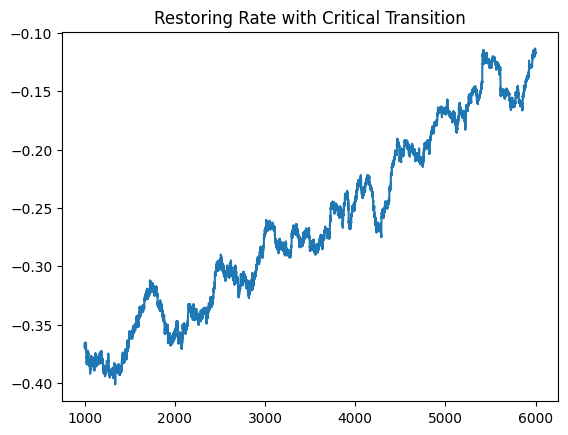

In [216]:
plt.title("Restoring Rate with Critical Transition")
plt.plot(t[10_000:60_000], model1_fit_a[10_000:60_000])

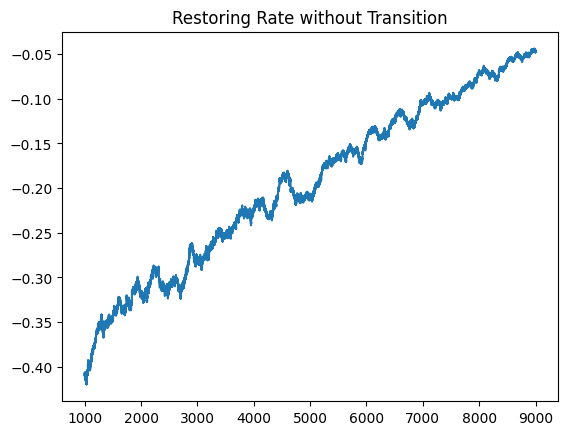

In [227]:
plt.title("Restoring Rate without Transition")
plt.plot(t[10_000:90_000], model2_fit_a[10_000:90_000])

Instead of fitting a linear model to the dx series, a genralised least squares model with auto-regrssive structure (GLSAR) can be used.

In [206]:
def run_fit_a_ar1(x, w):
    n = x.shape[0]
    xs = np.zeros_like(x)

    for i in range(w // 2):
        xs[i] = np.nan

    for i in range(n - w // 2, n):
        xs[i] = np.nan

    for i in range(w // 2, n - w // 2):
        xw = x[i - w // 2 : i + w // 2 + 1]
        xw = xw - xw.mean()

        p0, p1 = np.polyfit(np.arange(xw.shape[0]), xw, 1)
        xw = xw - p0 * np.arange(xw.shape[0]) - p1 # residuals


        dxw = xw[1:] - xw[:-1]

        xw = sm.add_constant(xw)
        model = sm.GLSAR(dxw, xw[:-1], rho=1) # generalized least squares with auto-regressive covariance structure
        results = model.iterative_fit(maxiter=10)

        a = results.params[1]

        xs[i] = a
    return xs

model1_fit_a_ar1 = run_fit_a_ar1(model1, 2000)
model2_fit_a_ar1 = run_fit_a_ar1(model2, 2000)

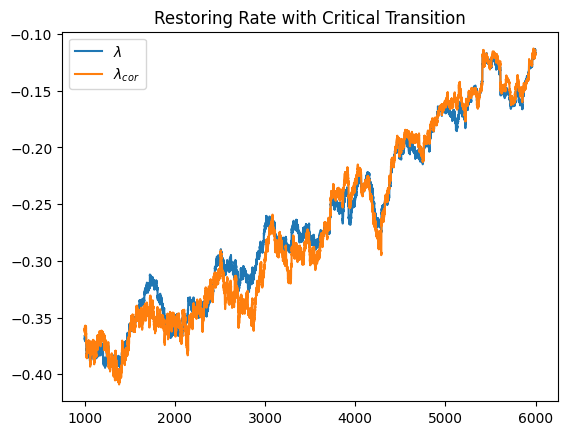

In [224]:
plt.title("Restoring Rate with Critical Transition")
plt.plot(t[10_000:60_000], model1_fit_a[10_000:60_000], label="$\u03bb$")
plt.plot(t[10_000:60_000], model1_fit_a_ar1[10_000:60_000], label="$\u03bb_{cor}$")
plt.legend()

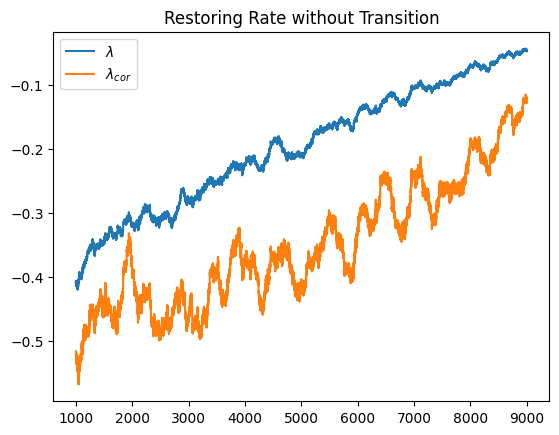

In [225]:
plt.title("Restoring Rate without Transition")
plt.plot(t[10_000:90_000], model2_fit_a[10_000:90_000], label="$\u03bb$")
plt.plot(t[10_000:90_000], model2_fit_a_ar1[10_000:90_000], label="$\u03bb_{cor}$")
plt.legend()